# Instalación de la librería y carga

In [1]:
!pip install -U git+https://github.com/jdvelasq/techminer 

  Created wheel for techminer: filename=techminer-0.0.0-py3-none-any.whl size=11596879 sha256=f2733120d9171aadf13a7c4c6c2fc5afcf0e19f8dc3d3b4a93ff23cfd1184a66
  Stored in directory: /tmp/pip-ephem-wheel-cache-kwgq444y/wheels/aa/18/f7/aa9254dab5830ecf636ab83204c19fb41b997bf4618088120f
Successfully built techminer
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Carga de datos desde excel

In [2]:
import pandas as pd

pdf = pd.read_excel('RSL.xlsx', encoding='latin', usecols=list(range(18)))
print(pdf.columns)
print()
print('Numero de registros=', len(pdf))

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Volume',
       'Issue', 'Page start', 'Page end', 'Page count', 'Cited by', 'DOI',
       'Link', 'Abstract', 'Author Keywords', 'Index Keywords', 'Affiliations',
       'References'],
      dtype='object')

Numero de registros= 200


# Carga de datos a techminer

In [3]:
import techminer

In [4]:
# Carga los datos bibliográficos
rdf = techminer.RecordsDataFrame(pdf)
rdf.index = range(len(rdf))
rdf = techminer.nan2none(rdf)
rdf.columns.tolist()

['Authors',
 'Author(s) ID',
 'Title',
 'Year',
 'Source title',
 'Volume',
 'Issue',
 'Page start',
 'Page end',
 'Page count',
 'Cited by',
 'DOI',
 'Link',
 'Abstract',
 'Author Keywords',
 'Index Keywords',
 'Affiliations',
 'References']

# Revisión básica de registros

In [5]:
#
# Tipos de columnas y conteo de datos
#
rdf.info()

<class 'techminer.dataframe.RecordsDataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Authors          200 non-null    object 
 1   Author(s) ID     200 non-null    object 
 2   Title            200 non-null    object 
 3   Year             200 non-null    int64  
 4   Source title     200 non-null    object 
 5   Volume           126 non-null    object 
 6   Issue            75 non-null     object 
 7   Page start       166 non-null    float64
 8   Page end         163 non-null    object 
 9   Page count       1 non-null      float64
 10  Cited by         149 non-null    float64
 11  DOI              156 non-null    object 
 12  Link             200 non-null    object 
 13  Abstract         200 non-null    object 
 14  Author Keywords  142 non-null    object 
 15  Index Keywords   176 non-null    object 
 16  Affiliations     197 non-null    object 
 17  Referen

In [6]:
#
# Cantidad de datos por columna
#
rdf.coverage()

,Field,Number of items,Coverage (%)
0,Authors,200,100.00%
1,Author(s) ID,200,100.00%
2,Title,200,100.00%
3,Year,200,100.00%
4,Source title,200,100.00%
5,Volume,126,63.00%
6,Issue,75,37.50%
7,Page start,166,83.00%
8,Page end,163,81.50%
9,Page count,1,0.50%


# Completación de palabras clave

In [7]:
#
# Convierte a minusculas
#
for field in ['Abstract', 'Author Keywords', 'Index Keywords']:
    rdf[field] = rdf[field].map(lambda x: x.lower() if isinstance(x, str) else x)

In [8]:
#
# Une los términos clave del artículo
#
rdf["Keywords"] = techminer.merge_fields(
    rdf["Author Keywords"], rdf["Index Keywords"], sepA=";", sepB=";", new_sep=";"
)

In [9]:
#
# Número de registros sin palabras clave al unir 
# index keyword & author keywords
#
len(rdf[rdf["Keywords"].map(lambda x: x is None)])

6

In [10]:
#
# Completación de las palabras clave
#

#
#   1. Remoción del copyright del abstract
#
import numpy as np

rdf["Abstract"] = rdf["Abstract"].map(
    lambda x: x[0 : x.find("\u00a9")]
    if isinstance(x, str) and x.find("\u00a9") != -1
    else x
)

#
#   2. Crea la unión del título y del abstract
#
title_abstract = techminer.merge_fields(rdf["Title"], rdf["Abstract"], new_sep=" ")

#
#   3. Crea un objeto para manejo de palabras clave
#      y adiciona las palabras clave de los artículos
#
kyw = techminer.Keywords()
kyw.add_keywords(rdf["Keywords"], sep=";")

#
#   4. Extrae las palabras del titulo y el abstract que concuerdan
#      con las palabras claves de los otros artículos
#
keywords_title_abstract = title_abstract.map(
    lambda x: kyw.extract_from_text(x, sep=";")
)

#
#   5. Completa las palabras clave para los artículos
#      sin palabras clave
#
idx = rdf["Keywords"].map(lambda x: x is None)
rdf.loc[idx, "Keywords"] = keywords_title_abstract[idx]

#
#   6. Verifica el número de artículos sin palabras clave
#
len(rdf[rdf["Keywords"].map(lambda x: x is None)])

0

# Limpieza de palabras clave

In [11]:
#
# Aplica text-collision para detectar cadenas que 
# similares o idénticas
# que podrían ser la misma
#
th = techminer.text_clustering(rdf['Keywords'], sep=';', transformer=lambda x: x.lower())

#
# Aplica el diccionario a las palabras clave
#
rdf["Keywords"] = rdf["Keywords"].map(lambda x: th.apply(x, sep=";"))

#
# Elimina espacios en blanco extra
#
rdf["Keywords"] = rdf["Keywords"].map(
    lambda x: ";".join(set([w.strip() for w in x.split(";")]))
)

#
# Cambia cadenas vacias por None
#
rdf["Keywords"] = rdf["Keywords"].map(
    lambda x: x if x != "" else None
)

#
# Convierte todas las letras a minúsculas
#
rdf["Keywords"] = rdf["Keywords"].map(
    lambda x: x.lower()
)

# Datos para clustering

In [12]:
#
#   1. Crea la unión del título, abstract y keywords
#
rdf['TitleAbstract'] = techminer.merge_fields(rdf["Title"], rdf["Abstract"], new_sep=" ")
rdf['TitleAbstract']

rdf['TAK'] = techminer.merge_fields(rdf['TitleAbstract'], rdf["Keywords"], new_sep=" ")
rdf['TAK'] = rdf['TAK'].map(lambda x: x.lower())

#
#   2. Crea un objeto para manejo de palabras clave
#      y adiciona las palabras clave de los artículos
#
kyw = techminer.Keywords()
kyw.add_keywords(rdf["Keywords"].map(lambda x: x.lower()), sep=";")

#
#   3. Extrae las palabras del titulo y el abstract que concuerdan
#      con las palabras claves de los otros artículos
#
rdf["AugKeywords"] = rdf["TAK"].map(
    lambda x: kyw.extract_from_text(x, sep=";")
)

th = techminer.text_clustering(rdf['AugKeywords'], sep=';', transformer=lambda x: x.lower())
rdf["AugKeywords"] = rdf["AugKeywords"].map(lambda x: th.apply(x, sep=";"))


rdf["AugKeywords"].head()

0    attention;attention mechanisms;behavior;behavi...
1    behavior;cues;design;devices;energy;habitual b...
2    activity contexts;activity mining;behavior;beh...
3    advanced metering infrastructures;behavior;beh...
4    artificial life;behavior;behavior estimation;b...
Name: AugKeywords, dtype: object

# Numeración de registros para referencias

In [13]:
rdf = techminer.RecordsDataFrame(rdf).generate_ID()

# Análisis

In [ ]:
#
# Numero de artículos
#
len(rdf)

In [ ]:
#
# Número de autores
#
len(rdf.documents_by_terms("Authors", sep=","))

In [ ]:
#
# Figura ?. Número de documentos por año
#
rdf.documents_by_year(cumulative=False).barhplot(figsize=(6,11))

In [ ]:
#
# Figura ?. Cantidad acumulada de documentos por año
#
rdf.documents_by_year(cumulative=True).barhplot(figsize=(6, 11))

In [ ]:
#
# Número de paises
#
rdf["Country"] = rdf["Affiliations"].map(lambda x: techminer.extract_country(x, sep=";"))
x = rdf.documents_by_terms("Country", sep=";")
print('Numero de paises = ', len(x))
print()
print(x.head(10))

In [ ]:
rdf.documents_by_terms("Country", sep=";").worldmap()

In [ ]:
#
# Tabla ?. Autores con tres o más publicaciones
#
rdf.documents_by_terms("Authors", sep=",", top_n=11)

In [ ]:
#
# Tabla ?. Citas por autor en la tabla anterior
#

m = {}
for _, w in rdf[['ID', 'Cited by']].iterrows():
    m[w['ID']] =  w['Cited by']
    
x = rdf.documents_by_terms("Authors", sep=",", top_n=10)
x['Cited by'] = x['ID'].map(lambda s: sum([ m[u] for u in s]))
x

In [ ]:
#
# Figura ?. Número de documentos por autor por año
#
rdf.terms_by_year(column="Authors", sep=",", top_n=10).heatmap(figsize=(4.5, 8))

In [ ]:
#
# Número de palabras clave
# 
len(rdf.documents_by_terms("Keywords", sep=";"))

In [ ]:
#
# Figura ?. Numero de documentos por palabra clave por año
#
rdf.terms_by_year(column="Keywords", sep=";", top_n=20).heatmap(
    figsize=(7, 11)
)

In [ ]:
#
# Figura ?. Co-ocurrencia de palabras clave para las 20 palabras
#           mas importantes
#
rdf.ocurrence(column="Keywords", sep=";", top_n=20).heatmap(
    ascending_r=True, ascending_c=True, figsize=(8, 8)
)

In [ ]:
#
# Figura ?. Co-ocurrencia autores - palabras clave
#
rdf.co_ocurrence(
    column_r="Authors", column_c="Keywords", sep_r=",", sep_c=";", top_n=30
).heatmap(ascending_r=True, ascending_c=True, figsize=(9, 8))

In [ ]:
#
# Figura ?. Co-autoria
#
rdf.auto_corr(column="Authors", sep=",", top_n=11).chord_diagram(figsize=(10, 10))

In [ ]:
#
# Total number of citations
#
rdf['Cited by'].sum()

In [ ]:
#
# Number of documents no cited by
#
len(rdf[rdf['Cited by'] == 0])

In [ ]:
rdf.most_cited_documents(top_n=20)

In [ ]:
#
# Tabla ?. Documentos más citados
#

t = rdf.most_cited_documents(top_n=15)['Title'].tolist()
a = rdf.most_cited_documents(top_n=15)['Authors'].tolist()
y = rdf.most_cited_documents(top_n=15)['Year'].tolist()
id = rdf.most_cited_documents(top_n=15)['ID'].tolist()

for x in zip(t, a, y, id):
    print(x[0]+'. '+x[1]+'. '+str(x[2])+'.'+x[3])
    print()

In [ ]:
#
# Tabla ?. Autores más citados
#
x = rdf.citations_by_terms('Authors', sep=',', top_n=20)
x['Num Documents'] = x['ID'].map(lambda x: len(x))
x[['Authors', 'Cited by', 'Num Documents']]

In [ ]:
#
# Figura ?. Citacion por autor por año
#
rdf.citations_by_terms_by_year("Authors", sep=",", top_n=20).heatmap(figsize=(8, 9))

In [ ]:
#
# Figura ?. Citaciones por keyword
#
rdf.citations_by_terms('Keywords', sep=';', top_n=20).barhplot(figsize=(6,8))

# Agrupamiento de artículos basado en keywords

In [14]:
x = rdf['AugKeywords'].map(lambda x: x.split(';')).tolist()
keyword_list = set()
for y in x:
    for w in y:
        keyword_list.add(w)
        
len(keyword_list)

1790

In [15]:
sorted(keyword_list)[:10], sorted(keyword_list)[-10:]

(['3-axis acceleration',
  '3-d sensing',
  '3d sensing',
  '3d skeleton',
  '3g',
  'a-priori',
  'a-train',
  'a-wavelet transform',
  'abnormal behavior',
  'abstract representation'],
 ['wireless networks',
  'wireless sensor networks',
  'wireless telecommunication systems',
  'work',
  'work efficiency',
  'work in progress',
  'worker performance',
  'working environment',
  'world wide web',
  'young adult'])

In [19]:
import pandas as pd

dtm = pd.DataFrame()
for keyword in keyword_list:
    dtm[keyword] = [0] * len(rdf)

In [20]:
len(dtm), len(dtm.columns)

(200, 1790)

In [23]:
sorted(dtm.columns)[0:10], sorted(dtm.columns)[-10:]

(['3-axis acceleration',
  '3-d sensing',
  '3d sensing',
  '3d skeleton',
  '3g',
  'a-priori',
  'a-train',
  'a-wavelet transform',
  'abnormal behavior',
  'abstract representation'],
 ['wireless networks',
  'wireless sensor networks',
  'wireless telecommunication systems',
  'work',
  'work efficiency',
  'work in progress',
  'worker performance',
  'working environment',
  'world wide web',
  'young adult'])

In [24]:
for idx, keywords in enumerate(rdf['AugKeywords']):
    if keywords is not None:
        for word in keywords.split(';'):
            dtm.at[idx, word] = 1

In [25]:
sorted(dtm.columns)[0:10], sorted(dtm.columns)[-10:]

(['3-axis acceleration',
  '3-d sensing',
  '3d sensing',
  '3d skeleton',
  '3g',
  'a-priori',
  'a-train',
  'a-wavelet transform',
  'abnormal behavior',
  'abstract representation'],
 ['wireless networks',
  'wireless sensor networks',
  'wireless telecommunication systems',
  'work',
  'work efficiency',
  'work in progress',
  'worker performance',
  'working environment',
  'world wide web',
  'young adult'])

In [26]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [ ]:
result = []
for k in range(2, 30):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(dtm)
    labels = kmeans_model.labels_
    result.append(metrics.silhouette_score(dtm, labels, metric='euclidean'))
    print(k, ' - ', result[-1])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(2,30), result, '.-')
plt.grid()

In [27]:
CLUSTERS = 5
kmeans_model = KMeans(n_clusters=CLUSTERS, random_state=1).fit(dtm)

In [30]:
kmeans_model.labels_

array([1, 3, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 4, 1, 1, 1, 2, 1, 2,
       3, 1, 1, 1, 1, 4, 1, 1, 2, 4, 1, 3, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 3, 1, 2, 3, 2, 4, 4, 4, 2, 2, 3, 3, 1, 2, 2, 4, 1, 2, 4, 4, 3,
       1, 1, 2, 4, 2, 1, 1, 1, 1, 2, 1, 3, 2, 4, 1, 2, 1, 4, 4, 2, 4, 1,
       2, 4, 4, 1, 1, 4, 2, 1, 2, 2, 4, 2, 4, 2, 2, 4, 4, 1, 1, 4, 1, 0,
       1, 2, 2, 3, 1, 4, 2, 3, 4, 1, 2, 2, 4, 2, 1, 4, 4, 3, 4, 1, 4, 1,
       1, 4, 3, 4, 1, 3, 1, 4, 4, 4, 2, 2, 1, 1, 2, 4, 1, 1, 1, 2, 1, 4,
       4, 1, 0, 4, 1, 4, 2, 1, 1, 4, 4, 4, 1, 3, 1, 1, 1, 1, 3, 4, 4, 4,
       3, 4], dtype=int32)

In [32]:
rdf['cluster'] = kmeans_model.labels_

In [35]:
rdf.to_excel('clusters.xls')

In [34]:
!pip install xlwt


     |################################| 99 kB 399 kB/s eta 0:00:011
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
for i in range(CLUSTERS):
    print(len(rdf[rdf.cluster == i]))

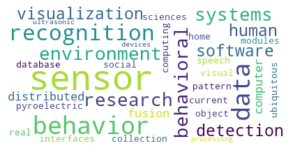

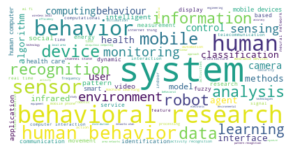

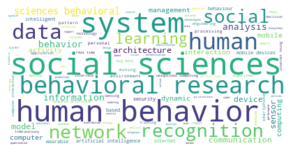

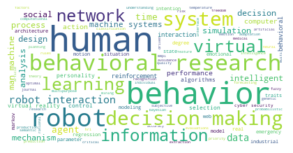

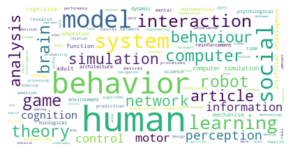

In [36]:
for i in range(CLUSTERS):
    techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).documents_by_terms('Keywords').wordcloud(figsize=(5, 5))

In [ ]:
for i in range(CLUSTERS):
    print(techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).most_cited_documents(top_n=15)['Title'])
    print('----')

# Otros

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

stemmed = rdf.References.apply(
    lambda x:  " ".join([stemmer.stem(w) for w in x.split()]) if isinstance(x, str) else None 
)

stemmed = stemmed[stemmed.map(lambda x: x is not None)]

stemmed.head(30)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=False,            # Los valores distintos de cero son fijados en 1
    min_df=1                # ignora palabras con baja freq
)

dtm = count_vect.fit_transform(stemmed)
dtm.shape

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

result = []


for k in range(2, 30):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(dtm)
    labels = kmeans_model.labels_
    result.append(metrics.silhouette_score(dtm, labels, metric='euclidean'))
    print(k, ' - ', result[-1])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(2,30), result, '.-')
plt.grid()

In [ ]:
CLUSTERS = 7
kmeans_model = KMeans(n_clusters=CLUSTERS, random_state=1).fit(dtm)

In [ ]:
rdf['cluster'] = None

In [ ]:
for pos, idx in enumerate(stemmed.index.tolist()):
    rdf.at[idx, 'cluster'] = kmeans_model.labels_[pos]

In [ ]:
for i in range(CLUSTERS):
    print(len(rdf[rdf.cluster == i]))

In [ ]:
for i in range(CLUSTERS):
    techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).documents_by_terms('Keywords').wordcloud(figsize=(5, 5))

In [ ]:
for i in range(CLUSTERS):
    print(techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).most_cited_documents(top_n=15)['Title'])
    print('----')

In [ ]:
# Crea la unión del título y del abstract
title_abs = techminer.merge_fields(rdf["Title"], rdf["Abstract"], new_sep=" ")
keywords_title_abs = techminer.merge_fields(title_abs, rdf["Keywords"], new_sep=" ")

# Crea un objeto para manejo de palabras clave
kyw = techminer.Keywords()

# Adiciona las palabras clave de los artículos
kyw.add_keywords(rdf["Keywords"], sep=";")

# Extrae las palabras del titulo y el abstract que concuerdan
# con las palabras claves de los otros artículos
aug_keywords = keywords_title_abs.map(
    lambda x: kyw.extract_from_text(x, sep=";")
)

# Clustering basado en journal de la referencia

In [ ]:
refs = rdf.References
refs = refs.map(lambda x: x.split(';') if x is not None else x)
refs = refs.map(lambda x: [w[0:w.find('http')+1] if 'http' in w else w for w in x] if x is not None else x)
refs = refs.map(lambda x: [w for w in x if ' pp. ' in w] if x is not None else x)
refs = refs.map(lambda x: [w[-100:] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[w.find('('):] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w for w in x if len(w) > 22] if x is not None else x)
refs = refs.map(lambda x: [w[1:] if len(w) > 90 else w   for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[w.find('('):] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[1:] if len(w) > 2 and not w[1].isdigit() else w for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[w.find('('):] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w for w in x if len(w) > 20] if x is not None else x)
refs = refs.map(lambda x: [w.lower() for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[w.find(')')+2:] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[:w.find(',')] for w in x] if x is not None else x)

In [ ]:
refs[1155]

In [ ]:
source_list = set()
for ref in refs:
    if ref is not None:
        for w in ref:
            source_list.add(w)

In [ ]:
len(source_list)

In [ ]:
import pandas as pd

dtm = pd.DataFrame()
for source in source_list:
    dtm[source] = [0] * len(refs)

In [ ]:
len(dtm)

In [ ]:
for idx, ref in enumerate(refs):
    if ref is not None:
        for w in ref:
            dtm.at[idx, w] = 1

In [ ]:
dtm.sum().sum()

In [ ]:
max(dtm.sum())

In [ ]:
len(dtm.columns)

In [ ]:
import networkx as nx

plt.figure(figsize=(8, 8))
graph = nx.Graph()
nodes = list(range(len(dtm)))
graph.add_nodes_from(nodes)


for icol in dtm.columns:
    
    rows = dtm[icol][dtm[icol] > 0].index.tolist()
    for i in rows:
        for j in rows:
            if j > i:
                graph.add_edge(i, j)
    

path_length = nx.shortest_path_length(graph)
distances = pd.DataFrame(index=graph.nodes(), columns=graph.nodes())
for row, data in path_length:
    for col, dist in data.items():
        distances.loc[row,col] = dist
distances = distances.fillna(distances.max().max())
layout = nx.kamada_kawai_layout(graph, dist=distances.to_dict())

In [ ]:
nx.draw(
    graph, 
    layout, 
)
plt.axis('off')

In [ ]:
result = []
for k in range(2, 15):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(dtm)
    labels = kmeans_model.labels_
    result.append(metrics.silhouette_score(dtm, labels, metric='euclidean'))
    print(k, ' - ', result[-1])
    
plt.plot(range(2,15), result, '.-')
plt.grid()

In [ ]:
CLUSTERS = 3
kmeans_model = KMeans(n_clusters=CLUSTERS, random_state=1).fit(dtm)

rdf['cluster'] = None
for pos, idx in enumerate(stemmed.index.tolist()):
    rdf.at[idx, 'cluster'] = kmeans_model.labels_[pos]

for i in range(CLUSTERS):
    print(len(rdf[rdf.cluster == i])) 
    
print()
print()
for i in range(CLUSTERS):
    print(techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).most_cited_documents(top_n=15)['Title'])
    print('----')    
    
for i in range(CLUSTERS):
    techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).documents_by_terms('Keywords').wordcloud(figsize=(5, 5))